In [1]:
%matplotlib inline

## Test interpolation of ice motion data for ICESat-2 tracks

In [9]:
import warnings
warnings.filterwarnings('ignore')

import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Our modules
sys.path.append('/home/jovyan/segtrax/source')
import utilities as ut
import reader as rd
from trajectory import Trajectory



In [4]:
filepath = '../data/ATL10-01_20181115003141_07240101_001_01.h5'
segment_id, segment_length, date, lons, lats, freeboard = rd.getATL10(filepath, beam='gt1l')

traj_list = []
for sid, slen, d, la, lo, fb in zip(segment_id, segment_length, date, lats, lons, freeboard):
        if fb > 1e38:
            continue
        traj_list.append(Trajectory(sid, slen, d, la, lo, fb))

ATL10 file: ../data/ATL10-01_20181115003141_07240101_001_01.h5


In [5]:
len(traj_list)

112817

In [6]:
lat = np.array([t.latitude for t in traj_list]).flatten()
lon = np.array([t.longitude for t in traj_list]).flatten()
hf = np.array([t.hf for t in traj_list]).flatten()

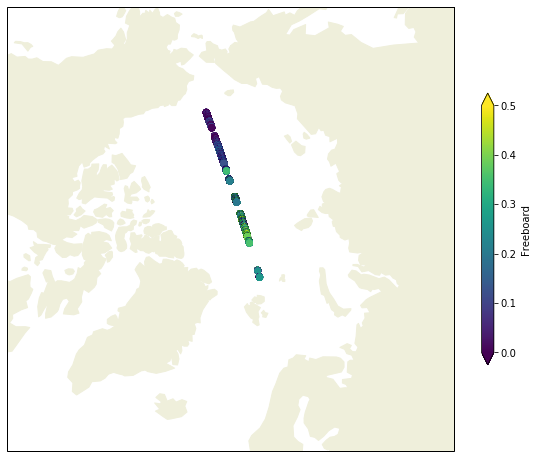

In [7]:
map_proj = ccrs.NorthPolarStereo()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=map_proj)
ax.set_extent([-180., 180., 60., 90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
sct = ax.scatter(lon, lat, c=hf, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5)
plt.colorbar(sct, label='Freeboard', shrink=0.5, extend='both')

## Get Ice Motion data

In [25]:
motion = rd.get_ice_motion('/home/jovyan/segtrax/data/ice_motion/icemotion*.nc').sortby('time')
motion 

<xarray.Dataset>
Dimensions:                 (time: 70, x: 361, y: 361)
Coordinates:
  * x                       (x) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * y                       (y) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * time                    (time) object 2018-01-01 12:00:00 ... 2019-04-30 00:00:00
Data variables:
    crs                     int32 -2147483647
    latitude                (y, x) float32 29.896942 30.080757 ... 29.896942
    longitude               (y, x) float32 -45.0 -44.8404 ... 135.15959 135.0
    u                       (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(52, 361, 361)>
    v                       (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(52, 361, 361)>
    number_of_observations  (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(52, 361, 361)>
Attributes:
    version:       4.1
    release_date:  April 2019
    Conventions:   CF-1.4
    citation:      Tschudi, M. A., Meier, W. 

In [49]:
motion.time[0].values

array(cftime.DatetimeJulian(2018, 1, 1, 12, 0, 0, 0, 6, 1), dtype=object)

In [12]:
xi, yi = ut.transform_coord(4326, 3408, lon, lat)

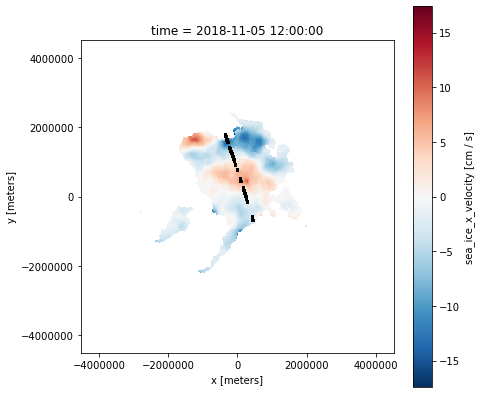

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
motion.sel(time='2018-11-05').u.plot(ax=ax)
ax.scatter(xi, yi, c='k', s=3)
ax.set_aspect('equal')

In [17]:
ui, vi = ut.interp_uv(motion.x, motion.y, 
                   motion.sel(time='2018-11-05').u.values, 
                   motion.sel(time='2018-11-05').v.values, 
                   xi, yi)
ui

array([-99.90000153, -99.90000153, -99.90000153, ...,  -2.32646145,
        -2.32605618,  -2.3256363 ])

In [18]:
ui[ui > -99.].size

105352

In [19]:
ui.size

112817

In [42]:
trj = traj_list[0]
k = 86400.*7.*1e-2  # Seconds in a week / centimeter per meter

# Get coordinates
t, lon, lat = trj.get_coords()
print (f'Initial location: {lat} N, {lon} E')

xi, yi = ut.transform_coord(4326, 3408, lon, lat)
print (f'Initial (x,y): {xi} m, {yi} m')

# Get u and v for xi and yi - need to select by time
ui, vi = ut.interp_uv(motion.x, motion.y, 
                   motion.sel(time='2018-11-05', method='nearest').u.values, 
                   motion.sel(time='2018-11-05', method='nearest').v.values, 
                   xi, yi)
print (f'Displacement: {k*ui} m, {k*vi} m')

xp = xi + k*ui
yp = yi + k*vi
print (f'New (x,y): {xp} m, {yp} m')

lonnew, latnew = ut.transform_coord(3408, 4326, xp, yp)
print (f'New location: {latnew} N, {lonnew} E')

Initial location: [73.4492946076648] N, [-168.4992941827544] E
Initial (x,y): [-365668.56886123656] m, [1797205.1136829911] m
Displacement: [-604195.20922852] m, [-604195.20922852] m
New (x,y): [-969863.77808975] m, [1193009.90445448] m
New location: [76.13964753] N, [-140.89042963] E


In [35]:
lonnew, latnew = ut.transform_coord(3408, 4326, 0., 0.)
print (lonnew, latnew)

180.0 90.0


In [37]:
xi, yi = ut.transform_coord(4326, 3408, 0., 0.)
print (xi, yi)

0.0 -9010277.046571208
